In [1]:
import sys
#sys.path.insert(0, '/home/jovyan/work/Molecular_Properties/model-pipeline/src')
import pandas as pd
import warnings
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#from model_construction import prepare_data_split, run_model, show_varimp
from bearinmind_pipeline.data_preprocessing import dataPreprocessing as dp
#from bearinmind_pipeline.model_construction import modelBuilder as mb
import bearinmind_pipeline.model_construction as mc
from numpy import inf
from sklearn.metrics import mean_squared_error
from math import sqrt
import gc
from tqdm import tqdm_notebook, tqdm 
import matplotlib.pyplot as plt
import datetime
import json
from scipy import stats
import holidays
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
import seaborn as sns
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Using TensorFlow backend.
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
mapping = pd.read_csv('./data/building_metadata.csv')

In [4]:
weather_train = pd.read_csv('./data/weather_train.csv')
weather_test = pd.read_csv('./data/weather_test.csv')

In [5]:
### Add Holidays ###
def get_holidays(df):
    en_holidays = holidays.England()
    ir_holidays = holidays.Ireland()
    ca_holidays = holidays.Canada()
    us_holidays = holidays.UnitedStates()
    en_idx = df.query('site_id == 1 or site_id == 5').index
    ir_idx = df.query('site_id == 12').index
    ca_idx = df.query('site_id == 7 or site_id == 11').index
    us_idx = df.query('site_id == 0 or site_id == 2 or site_id == 3 or site_id == 4 or site_id == 6 or site_id == 8 or site_id == 9 or site_id == 10 or site_id == 13 or site_id == 14 or site_id == 15').index
    df['IsHoliday'] = 0
    df.loc[en_idx, 'IsHoliday'] = df.loc[en_idx, 'timestamp'].apply(lambda x: en_holidays.get(x, default=0))
    df.loc[ir_idx, 'IsHoliday'] = df.loc[ir_idx, 'timestamp'].apply(lambda x: ir_holidays.get(x, default=0))
    df.loc[ca_idx, 'IsHoliday'] = df.loc[ca_idx, 'timestamp'].apply(lambda x: ca_holidays.get(x, default=0))
    df.loc[us_idx, 'IsHoliday'] = df.loc[us_idx, 'timestamp'].apply(lambda x: us_holidays.get(x, default=0))
    holiday_idx = df['IsHoliday'] != 0
    df.loc[holiday_idx, 'IsHoliday'] = 1
    df['IsHoliday'] = df['IsHoliday'].astype(np.uint8)
    
    return df

In [6]:
weather_train = get_holidays(weather_train)
weather_test = get_holidays(weather_test)

In [7]:
timediff = {0:4,1:0,2:7,3:4,4:7,5:0,6:4,7:4,8:4,9:5,10:7,11:4,12:0,13:5,14:4,15:4}
weather_train['timediff']= weather_train['site_id'].map(timediff)
weather_test['timediff']= weather_test['site_id'].map(timediff)

weather_train['timediff'] = weather_train['timediff'].apply(lambda x: datetime.timedelta(hours=x))
weather_test['timediff'] = weather_test['timediff'].apply(lambda x: datetime.timedelta(hours=x))

weather_train['timestamp'] = pd.to_datetime(weather_train['timestamp']) 
weather_test['timestamp'] = pd.to_datetime(weather_test['timestamp'])

weather_train['timestamp'] = weather_train['timestamp'] - weather_train['timediff']
weather_test['timestamp'] = weather_test['timestamp'] - weather_test['timediff']

In [8]:
weather_train.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,timediff
0,0,2015-12-31 20:00:00,25.000,6.000,20.000,nan,1019.700,0.000,0.000,1,04:00:00
1,0,2015-12-31 21:00:00,24.400,nan,21.100,-1.000,1020.200,70.000,1.500,1,04:00:00
2,0,2015-12-31 22:00:00,22.800,2.000,21.100,0.000,1020.200,0.000,0.000,1,04:00:00
3,0,2015-12-31 23:00:00,21.100,2.000,20.600,0.000,1020.100,0.000,0.000,1,04:00:00
4,0,2016-01-01 00:00:00,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1,04:00:00


In [9]:
df_train = df_train.merge(mapping, how = "left", on = "building_id")
df_test = df_test.merge(mapping, how = "left", on = "building_id")

In [10]:
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

In [11]:
df_train = df_train.merge(weather_train, how = "left", on = ["site_id", "timestamp"])
df_test = df_test.merge(weather_test, how = "left", on =  ["site_id", "timestamp"])

In [12]:
del weather_train 
del weather_test

In [13]:
df_train = df_train.drop(['timediff'], axis = 1)
df_test = df_test.drop(['timediff'], axis = 1)

In [14]:
def rmsle(y, yhat):
    score = np.sqrt(np.mean(np.power(np.log(yhat+1)-np.log(y.reset_index(drop=True)+1), 2)))
    return(score)

In [15]:
# Check one building
df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [16]:
### Intrapolate cloud coverage
df_train['cloud_coverage'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1,limit_direction = "both", limit = 1000))
df_test['cloud_coverage'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both", limit = 1000))

In [17]:
### Intrapolate air temperature
df_train['air_temperature'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))
df_test['air_temperature'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].apply(lambda x : x.interpolate(method = "spline", order = 1, limit_direction = "both"))

In [18]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday
0,0,0,2016-01-01,0.000,0,Education,7432,2008.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000
1,1,0,2016-01-01,0.000,0,Education,2720,2004.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000
2,2,0,2016-01-01,0.000,0,Education,5376,1991.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000
3,3,0,2016-01-01,0.000,0,Education,23685,2002.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000
4,4,0,2016-01-01,0.000,0,Education,116607,1975.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000


In [19]:
#### Take a Sample ####
#df_train = df_train.sample(n=int(df_train.shape[0]*0.1), random_state=1)
#df_test = df_test.sample(n=int(df_test.shape[0]*0.1), random_state=1)

In [20]:
#df_train["Month"] = pd.to_datetime(df_train["timestamp"]).dt.month
#df_test["Month"] = pd.to_datetime(df_test["timestamp"]).dt.month

In [21]:
df_train["Day"] = pd.to_datetime(df_train["timestamp"]).dt.day
df_test["Day"] = pd.to_datetime(df_test["timestamp"]).dt.day

In [22]:
df_train["Hour"] = pd.to_datetime(df_train["timestamp"]).dt.hour
df_test["Hour"] = pd.to_datetime(df_test["timestamp"]).dt.hour

In [23]:
#df_train.to_csv("df_train.csv", index = False)
#df_test.to_csv("df_test.csv", index = False)

In [24]:
#df_train = pd.read_csv('./df_train.csv')
#df_test = pd.read_csv('./df_test.csv')

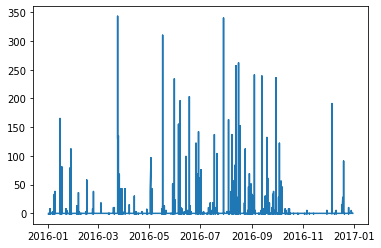

In [25]:
plt.plot(pd.to_datetime(df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['timestamp']).dt.date, df_train[(df_train['building_id']==0) & (df_train['meter']==0)]['precip_depth_1_hr'])

In [26]:
df_train['precip_depth_1_hr'] = df_train.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['precip_depth_1_hr'] = df_test.groupby(['building_id', 'meter'])['precip_depth_1_hr'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [27]:
df_train['sea_level_pressure'] = df_train.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['sea_level_pressure'] = df_test.groupby(['building_id', 'meter'])['sea_level_pressure'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [28]:
df_train['wind_direction'] = df_train.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_direction'] = df_test.groupby(['building_id', 'meter'])['wind_direction'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [29]:
df_train['wind_speed'] = df_train.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['wind_speed'] = df_test.groupby(['building_id', 'meter'])['wind_speed'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [30]:
df_train['dew_temperature'] = df_train.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))
df_test['dew_temperature'] = df_test.groupby(['building_id', 'meter'])['dew_temperature'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [31]:
df_train["DayOfWeek"] = pd.to_datetime(df_train["timestamp"]).dt.dayofweek
df_test["DayOfWeek"] = pd.to_datetime(df_test["timestamp"]).dt.dayofweek

In [32]:
df_train.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek
0,0,0,2016-01-01,0.000,0,Education,7432,2008.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000,1,0,4
1,1,0,2016-01-01,0.000,0,Education,2720,2004.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000,1,0,4
2,2,0,2016-01-01,0.000,0,Education,5376,1991.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000,1,0,4
3,3,0,2016-01-01,0.000,0,Education,23685,2002.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000,1,0,4
4,4,0,2016-01-01,0.000,0,Education,116607,1975.000,nan,20.000,2.000,20.000,-1.000,1020.000,250.000,2.600,1.000,1,0,4


In [33]:
#df_train = dp.create_stats_features(df_train, 'dew_temperature', ['site_id', 'Month'])
#df_test = dp.create_stats_features(df_test, 'dew_temperature', ['site_id', 'Month'])

In [34]:
#df_train["air_temperature_log"] = np.log(df_train['air_temperature'])
#df_test["air_temperature_log"] = np.log(df_test['air_temperature'])

In [35]:
#df_train["Age"] = pd.to_datetime(df_train["timestamp"]).dt.year - df_train["year_built"]
#df_test["Age"] = pd.to_datetime(df_test["timestamp"]).dt.year - df_test["year_built"]

In [36]:
### Clean Electricity ###
df_train = df_train[~((df_train['site_id'] == 0) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-20 18:00:00')))]

In [37]:
df_train = df_train[~((df_train['building_id'] == 799) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-01 12:00:00')))]
df_train = df_train[~((df_train['building_id'] == 802) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-23 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 803) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')))]

In [38]:
# df_train.to_csv("df_train.csv.gz", index = False, compression = 'gzip')
# df_test.to_csv("df_test.csv.gz", index = False, compression = 'gzip')

In [39]:
# df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
# df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [40]:
### Lags for cloud coverage and air temperature
#for i in range(12):
#    df_train[f'cloud_coverage_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_test[f'cloud_coverage_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['cloud_coverage'].shift(i+1)
#    df_train[f'air_temperature_lag{i+1}'] = df_train.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)
#    df_test[f'air_temperature_lag{i+1}'] = df_test.groupby(['building_id', 'meter'])['air_temperature'].shift(i+1)

In [41]:
### Drop zero values in Electricity ###
df_train = df_train.drop(df_train[(df_train['meter'] == 0) 
                       & (df_train['meter_reading'] == 0.0)].index)

In [42]:
def create_add_features(df):
    df['relative_humidity'] = 100-5*(df['air_temperature'] - df['dew_temperature'])
    df['air_density_dry'] = df['sea_level_pressure']/(287.058 * df['air_temperature'])
    df['vapor_pressure_water_satur'] = 6.102*10**((7.5*df['air_temperature'])/(df['air_temperature']+237.8))
    df['vapor_pressure_water'] =  df['relative_humidity']*df['vapor_pressure_water_satur']
    df['partial_press_dry'] = df['sea_level_pressure']-df['vapor_pressure_water'] 
    df['air_density_humid'] = (df['partial_press_dry']*0.0289654+df['vapor_pressure_water'] *0.018016)/8.314*df['air_temperature']
    
    return df

In [43]:
df_train = create_add_features(df_train)

In [44]:
df_train = df_train[~((df_train['building_id'] == 106) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-01 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 112) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-01 08:00:00')))]
df_train = df_train[~((df_train['building_id'] == 144) & (df_train['meter'] == 0) & 
                      (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-08 13:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-11 16:00:00')))]
df_train = df_train[~((df_train['building_id'] == 107) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-06 12:00:00')) | 
                     (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-11-10 02:00:00'))))]

In [45]:
df_train = df_train[~((df_train['building_id'] == 740) & (df_train['meter'] == 0))] 

In [46]:
df_train = df_train[~((df_train['building_id'] == 1241) & (df_train['meter'] == 3) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-22 14:00:00')))]

In [47]:
df_train = df_train[~((df_train['building_id'] == 60) & (df_train['meter'] == 1) & (df_train['meter_reading'] > 5000))] 

In [48]:
df_train = df_train[~((df_train['building_id'] == 103) & (df_train['meter'] == 1) & (df_train['meter_reading'] > 5000))] 

In [49]:
df_train = df_train[~((df_train['building_id'] == 799) & (df_train['meter'] == 0) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-03 13:00:00')))]

In [50]:
df_train = df_train[~((df_train['building_id'] == 751) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-03 07:00:00')))]

In [51]:
df_train = df_train[~((df_train['building_id'] == 758) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-07 12:00:00')))]

In [52]:
df_train = df_train[~((df_train['building_id'] == 783) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-12-09 14:00:00')))]  

In [53]:
df_train = df_train[~((df_train['building_id'] == 1238) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-20 14:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-26 20:00:00'))))]

In [54]:
df_train = df_train[~((df_train['building_id'] == 1250) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-12-21 16:00:00')))]  

In [55]:
df_train = df_train[~((df_train['building_id'] == 1303) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-15 12:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-06 19:00:00'))))]       

In [56]:
df_train = df_train[~((df_train['building_id'] == 1072) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-25 13:00:00')))]  

In [57]:
df_train = df_train[~((df_train['building_id'] == 1176) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-10 16:00:00')))]   

In [58]:
df_train = df_train[~((df_train['building_id'] == 1189) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-10 16:00:00')))]   

In [59]:
df_train = df_train[~((df_train['building_id'] == 188) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-09 15:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-07 13:00:00'))))]  

In [60]:
df_train = df_train[~((df_train['building_id'] == 190) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-08 10:00:00')))]   

In [61]:
df_train = df_train[~((df_train['building_id'] == 207) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-07-02 20:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-25 12:00:00'))))]  

In [62]:
df_train = df_train[~((df_train['building_id'] == 236) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-23 12:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-03-21 13:00:00'))))] 

In [63]:
df_train = df_train[~((df_train['building_id'] == 264) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-08 11:00:00')))]          

In [64]:
df_train = df_train[~((df_train['building_id'] == 260) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-10 21:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-17 11:00:00'))))] 

In [65]:
df_train = df_train[~((df_train['building_id'] == 260) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-08-28 02:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-31 13:00:00'))))] 

In [66]:
df_train = df_train[~((df_train['building_id'] == 895) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-12 10:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-04-28 16:00:00'))))]         

In [67]:
df_train = df_train[~((df_train['building_id'] == 932) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-02-04 08:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-04-28 10:00:00'))))] 

In [68]:
df_train = df_train[~((df_train['building_id'] == 954) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-08 11:00:00')))]   

In [69]:
df_train = df_train[~((df_train['building_id'] == 972) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-01 09:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-22 12:00:00'))))] 

In [70]:
df_train = df_train[~((df_train['building_id'] == 1223) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-03-30 19:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-08 11:00:00'))))] 

In [71]:
df_train = df_train[~((df_train['building_id'] == 1230) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-08-22 08:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-05 18:00:00'))))] 

In [72]:
df_train = df_train[~((df_train['building_id'] == 1232) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-06-23 09:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-31 19:00:00'))))] 

In [73]:
df_train = df_train[~((df_train['building_id'] == 1246) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-03-02 19:00:00')))]   

In [74]:
df_train = df_train[~((df_train['building_id'] == 1288) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-07-07 15:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-10 18:00:00'))))] 

In [75]:
df_train = df_train[~((df_train['building_id'] == 693) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-07 00:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-23 00:00:00'))))] 

In [76]:
df_train = df_train[~((df_train['building_id'] == 693) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-16 00:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-07-12 00:00:00'))))] 

In [77]:
df_train = df_train[~((df_train['building_id'] == 723) & (df_train['meter'] == 0) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-10-06 00:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-22 00:00:00'))))] 

In [78]:
df_train = df_train[~((df_train['building_id'] == 1130) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-09-30 13:00:00')))]          

In [79]:
df_train = df_train[~((df_train['building_id'] == 1160) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-14 10:00:00')))]          

In [80]:
df_train = df_train[~((df_train['building_id'] == 1227) & (df_train['meter'] == 3) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-26 15:00:00')))]          

In [81]:
df_train = df_train[~((df_train['building_id'] == 1244) & (df_train['meter'] == 3) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-04-04 21:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-06 18:00:00'))))] 

In [82]:
df_train = df_train[~((df_train['building_id'] == 1246) & (df_train['meter'] == 3) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-03-02 19:00:00')))]          

In [83]:
df_train = df_train[~((df_train['building_id'] == 769) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-07-19 09:00:00')))]          

In [84]:
df_train = df_train[~((df_train['building_id'] == 954) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-08 11:00:00')))]          

In [85]:
#df_train.to_csv("df_train.csv.gz", index = False, compression = 'gzip')

In [86]:
# df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
# df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [87]:
df_train = df_train[~((df_train['building_id'] == 1349) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-04-26 14:00:00')))]          

In [88]:
df_train = df_train[~((df_train['building_id'] == 1382) & 
                      (df_train['meter'] == 1) & ((pd.to_datetime(df_train['timestamp']) == pd.to_datetime('2016-01-01 05:00:00')) | 
                                                  (pd.to_datetime(df_train['timestamp']) == pd.to_datetime('2016-01-01 14:00:00')) | 
                                                  (pd.to_datetime(df_train['timestamp']) == pd.to_datetime('2016-01-11 08:00:00'))
                                                  ))]                 

In [89]:
df_test = create_add_features(df_test)

In [90]:
### May be remove
for i in [753, 765, 771, 777, 787, 745, 750, 755, 769, 770, 776]:
    df_train.loc[(df_train['building_id'] == i) & 
                 (df_train['meter'] == 1)] = df_train[(df_train['building_id'] == i) & 
                                                      (df_train['meter'] == 1)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == i) & 
                                                                                                              (df_train['meter'] == 1)]['meter_reading'])) < 6)]

In [91]:
df_train.loc[(df_train['building_id'] == 762) & 
                 (df_train['meter'] == 2)] = df_train[(df_train['building_id'] == 762) & 
                                                      (df_train['meter'] == 2)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == 762) & 
                                                                                                              (df_train['meter'] == 2)]['meter_reading'])) < 10)]

In [92]:
df_train.loc[(df_train['building_id'] == 776) & 
                 (df_train['meter'] == 2)] = df_train[(df_train['building_id'] == 776) & 
                                                      (df_train['meter'] == 2)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == 776) & 
                                                                                                              (df_train['meter'] == 2)]['meter_reading'])) < 20)]

In [93]:
df_train = df_train[~((df_train['building_id'] == 770) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-01-08 11:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-02-03 14:00:00'))))] 

In [94]:
df_train.to_csv("df_train.csv.gz", index = False, compression = 'gzip')
df_test.to_csv("df_test.csv.gz", index = False, compression = 'gzip')

In [2]:
df_train = pd.read_csv('./df_train.csv.gz', compression = 'gzip')
df_test = pd.read_csv('./df_test.csv.gz', compression = 'gzip')

In [12]:
# ### May be remove
# for i in [874,895,899,918,942]:
#     df_train.loc[(df_train['building_id'] == i) & 
#                  (df_train['meter'] == 1)] = df_train[(df_train['building_id'] == i) & 
#                                                       (df_train['meter'] == 1)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == i) & 
#                                                                                                               (df_train['meter'] == 1)]['meter_reading'])) < 6)]

In [13]:
# ### May be remove
# for i in [1017,1018, 1022]:
#     df_train.loc[(df_train['building_id'] == i) & 
#                  (df_train['meter'] == 1)] = df_train[(df_train['building_id'] == i) & 
#                                                       (df_train['meter'] == 1)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == i) & 
#                                                                                                               (df_train['meter'] == 1)]['meter_reading'])) < 6)]

In [14]:
# ### May be remove
# for i in [1017,1018, 1000]:
#     df_train.loc[(df_train['building_id'] == i) & 
#                  (df_train['meter'] == 3)] = df_train[(df_train['building_id'] == i) & 
#                                                       (df_train['meter'] == 3)][(np.abs(stats.zscore(df_train[(df_train['building_id'] == i) & 
#                                                                                                               (df_train['meter'] == 3)]['meter_reading'])) < 8)]

In [24]:
df_train = df_train[~((df_train['building_id'] == 1167) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-18 15:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-25 08:00:00'))))] 

In [25]:
df_train = df_train[~((df_train['building_id'] == 1099) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-06-16 22:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-09 00:00:00'))))] 

In [26]:
df_train = df_train[~((df_train['building_id'] == 1099) & (df_train['meter'] == 2) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-11-12 05:00:00')))]          

In [27]:
df_train = df_train[~((df_train['building_id'] == 1129) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-13 18:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-06 11:00:00'))))] 

In [28]:
df_train = df_train[~((df_train['building_id'] == 1158) & (df_train['meter'] == 2) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-27 17:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-29 16:00:00'))))]         

In [32]:
for i in [1225, 1226]:
    df_train = df_train[~((df_train['building_id'] == i) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-08-22 23:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-20 13:00:00'))))]   

In [33]:
for i in [1233, 1234]:
    df_train = df_train[~((df_train['building_id'] == i) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-28 03:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-20 13:00:00'))))] 

In [34]:
for i in [1233, 1234]:
    df_train = df_train[~((df_train['building_id'] == i) & (df_train['meter'] == 1) & (pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-11-09 15:00:00')))]          

In [35]:
for i in [1264, 1293, 1295, 1296, 1297, 1300]:
    df_train = df_train[~((df_train['building_id'] == i) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-28 07:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-20 13:00:00'))))] 

In [38]:
df_train = df_train[~((df_train['building_id'] == 1264) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-08-22 17:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-09-22 20:00:00'))))]

In [39]:
df_train = df_train[~((df_train['building_id'] == 1280) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-02-28 23:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-05-02 08:00:00'))))]

In [40]:
df_train = df_train[~((df_train['building_id'] == 1273) & (df_train['meter'] == 1) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-05-31 14:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-17 00:00:00'))))]

In [ ]:
for i in [1223, 1272, 1275, 1276]:
    df_train = df_train[~((df_train['building_id'] == i) & (df_train['meter'] == 3) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-28 07:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-20 13:00:00'))))] 

In [349]:
df_train = df_train[~((df_train['building_id'] == 1235) & (df_train['meter'] == 3) & 
                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-04-04 21:00:00')) & 
                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-06-17 00:00:00'))))]

In [368]:
# for i in [1225, 1291, 1292, 1295, 1298, 1226, 1293, 1294, 1296, 1297, 1299]:
#     df_train = df_train[~((df_train['building_id'] == i) & (df_train['meter'] == 2) & 
#                       ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-09-28 07:00:00')) & 
#                      (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-10-20 13:00:00'))))]

In [395]:
# df_train = df_train[~((df_train['building_id'] == 1243) & (df_train['meter'] == 2) & 
#                       ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-10-19 14:00:00')) & 
#                      (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-11-08 21:00:00'))))]

In [399]:
#df_train = df_train[~((df_train['building_id'] == 1288) & (df_train['meter'] == 2) & 
#                      ((pd.to_datetime(df_train['timestamp']) > pd.to_datetime('2016-07-08 17:00:00')) & 
#                     (pd.to_datetime(df_train['timestamp']) < pd.to_datetime('2016-08-10 19:00:00'))))]

In [261]:
### Might cause overfit !!! ###
#def create_season(df):
#    df['Season'] = pd.to_datetime(df['timestamp']).apply(lambda dt: (dt.month%12 + 3)//3)
#    return(df)

In [262]:
#df_train = create_season(df_train)
#df_test = create_season(df_test)

In [265]:
#df_test['Season'].value_counts()

3    10510080
2    10510080
4    10395840
1    10281600
Name: Season, dtype: int64

In [223]:
#def filter_outliers(df):
#    if ((df.building_id.isin([753, 765, 771, 777, 787, 745, 750, 755, 769, 770, 776])).all() & (df.meter == 1).all()):
#        df_outl = df[(np.abs(stats.zscore(df['meter_reading'])) < 6)]
#    else:
#        df_outl = df
#    return(df_outl)

In [227]:
#df_train = df_train.groupby(['building_id', 'meter'], as_index=False).apply(lambda x: filter_outliers(x))

In [105]:
### Log of Square fit plus year build ###
#df_train['year_built'] = df_train['year_built'] - 1900
#df_train['square_feet'] = np.log(df_train['square_feet'])
#df_test['year_built'] = df_test['year_built'] - 1900
#df_test['square_feet'] = np.log(df_test['square_feet'])

In [106]:
def roll_diff(x):
    return x[0] - x[-1]

In [107]:
def check_constants(grp):
    grp['is_constant_meter'] = grp['meter_reading'].rolling(6).apply(roll_diff)
    return grp

In [108]:
# calculate rolling diff for constant detection
#df_train = df_train.groupby(['building_id', 'meter'], as_index = False).apply(lambda x: check_constants(x))

In [503]:
df_train.shape

(19682552, 21)

In [504]:
# convert constant meter readings to nan
#df_train.loc[df_train['is_constant_meter'] == 0.0, 'meter_reading'] = np.nan
#df_train = df_train[df_train['is_constant_meter'] != 0.0]

In [351]:
#df_train['meter_reading'].isnull().sum()
#df_train.shape

2255180

In [439]:
#def replace_na_with_prophet(df):
#    
#    test_prof = df[['timestamp', 'meter_reading', 'air_temperature']]
#    test_prof.columns = ["ds", "y", "air_temperature"]
#    z = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True,
#           seasonality_mode = 'multiplicative')
#    z.add_regressor('air_temperature')
#    z.fit(test_prof)
#    forecast = z.predict(test_prof)
#    df = df.reset_index(drop = True)
#    df['meter_reading'] = forecast['yhat']
    
#    #print(f'Itheration {i} is finished')
    
#    return(df)

In [429]:
#test_prft = df_train[(df_train['site_id'] == 0) & (df_train['meter'] == 1)]

In [ ]:
# Replace constants with prophet
#%time df_train = df_train.groupby(['building_id', 'meter'], as_index=False).apply(lambda x: replace_na_with_prophet(x))

In [ ]:
#df_train = df_train.reset_index(drop = True)

In [ ]:
#df_train.to_csv("df_train_prophet_for_constants.csv.gz", index = False, compression = 'gzip')

In [28]:
df_train[(df_train['site_id'] == 11) & (df_train['meter'] == 3)]['building_id'].unique()

array([1029., 1030., 1031., 1032., 1028.])

In [303]:
# Intrapolate nan values of meter reading 
#test['meter_reading'] = test.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "piecewise_polynomial", order = 5, limit_direction = "both"))
#def rolling_interpol(df):
#    roll_wind = df['meter_reading'].isnull().sum()
#    if roll_wind == 0:
#        pass
#    else:
#        df['meter_reading'] = df.meter_reading.fillna(df.meter_reading.rolling(roll_wind, min_periods=1).mean())
#    return df

In [304]:
#df_train = df_train.groupby(['building_id', 'meter']).apply(lambda x : rolling_interpol(x))

In [354]:
#df_train['meter_reading'] = df_train.groupby(['building_id', 'meter'])['meter_reading'].apply(lambda x : x.interpolate(method = "linear", order = 1, limit_direction = "both"))

In [620]:
df_train[df_train['meter_reading'].isnull()].shape

(0, 20)

In [169]:
test = df_train[(df_train['meter'] == 2) & (df_train['site_id'] == 15)] 

In [ ]:
for i in test['building_id'].unique():
    test_plot = test[test['building_id'] == i] 
    plt.figure(figsize=(15,15))
    plt.plot(pd.to_datetime(test_plot["timestamp"]).dt.date, test_plot['meter_reading'])
    plt.title(f'building_id: {i}')

# 

In [639]:
#test_prof = test[['timestamp', 'meter_reading', 'air_temperature', 'cloud_coverage', 'wind_direction',
#                 'sea_level_pressure']]
#test_prof.columns = ["ds", "y", "air_temperature", "cloud_coverage", "wind_direction", "sea_level_pressure"]

#### Testing Prophet ####

#z = Prophet(interval_width=0.95, daily_seasonality=True, weekly_seasonality=True,
#           seasonality_mode = 'multiplicative')
#z.add_seasonality(name='monthly', period=30.5, fourier_order=5)
#z.add_regressor('wind_direction')
#z.add_regressor('air_temperature')
#z.add_regressor('cloud_coverage')
#z.add_regressor('sea_level_pressure')
#z.fit(test_prof)
#forecast = z.predict(test_prof)

In [640]:
#rmsle(test_prof['y'],forecast['yhat'])

In [641]:
#plt.figure(figsize=(15,15))
#plt.plot(pd.to_datetime(forecast["ds"]).dt.date, forecast['yhat'])

In [642]:
#test = test.reset_index(drop = True)
#test['meter_reading'] = forecast['yhat']

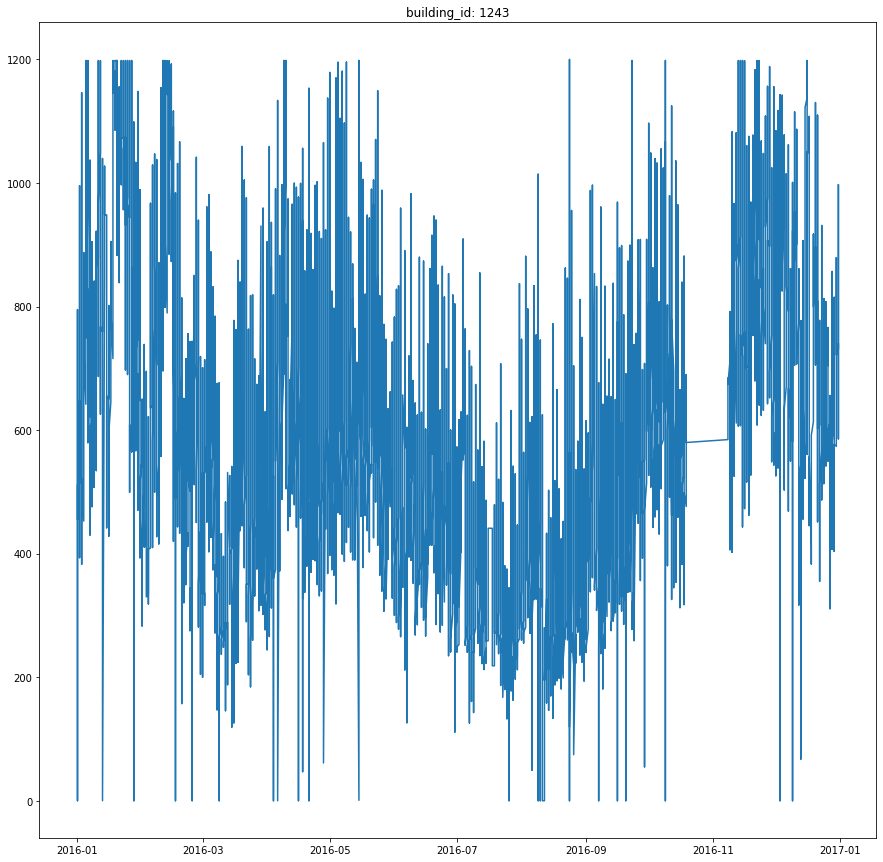

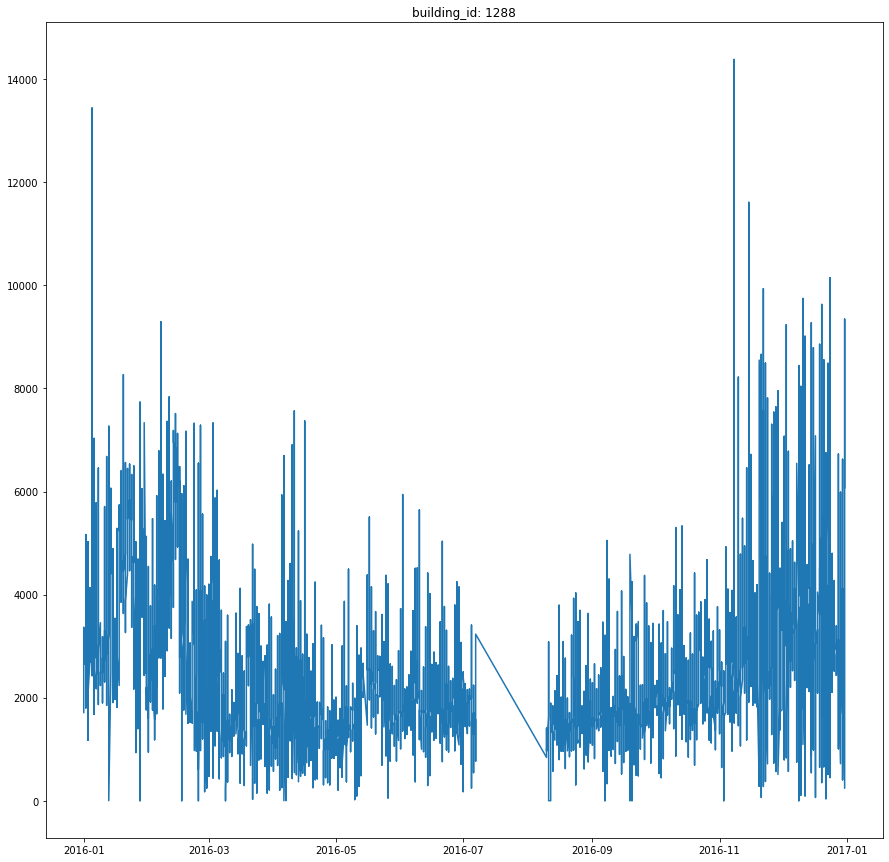

In [400]:
for i in [1243, 1288]:
    test = df_train[(df_train['building_id'] == i) & (df_train['meter'] == 2)]
    #z = np.abs(stats.zscore(test['meter_reading']))
    #pd.Series(z).describe()
    #plt.figure(figsize=(15,15))
    #plt.plot(z)
    #plt.title(f'building_id: {i}')
    plt.figure(figsize=(15,15))
    plt.plot(pd.to_datetime(test["timestamp"]).dt.date, test['meter_reading'])
    plt.title(f'building_id: {i}')

In [397]:
test = df_train[(df_train['building_id'] == 1288) & (df_train['meter'] == 2)]

In [275]:
test.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid
1747,1300.000,1.000,2016-01-01 00:00:00,186.223,14.000,Healthcare,25609.000,nan,nan,5.000,-0.599,-2.200,0.000,1019.200,290.000,3.100,1.000,1.000,0.000,4.000,64.000,0.710,8.708,557.314,461.886,14.084
3900,1300.000,1.000,2016-01-01 01:00:00,158.300,14.000,Healthcare,25609.000,nan,nan,4.400,-0.426,-2.200,0.000,1018.900,300.000,4.100,1.000,1.000,1.000,4.000,67.000,0.807,8.351,559.497,459.403,12.377
6059,1300.000,1.000,2016-01-01 02:00:00,168.197,14.000,Healthcare,25609.000,nan,nan,4.400,-0.253,-2.800,0.000,1018.400,300.000,2.600,1.000,1.000,2.000,4.000,64.000,0.806,8.351,534.445,483.955,12.514
8215,1300.000,1.000,2016-01-01 03:00:00,131.289,14.000,Healthcare,25609.000,nan,nan,3.900,-0.080,-2.800,0.000,1018.200,300.000,3.600,1.000,1.000,3.000,4.000,66.500,0.909,8.063,536.181,482.019,11.081
10371,1300.000,1.000,2016-01-01 04:00:00,98.230,14.000,Healthcare,25609.000,nan,nan,3.900,0.000,-3.300,0.000,1018.300,300.000,4.100,1.000,1.000,4.000,4.000,64.000,0.910,8.063,516.024,502.276,11.186


In [135]:
#x = test['wind_direction'].value_counts()

In [398]:
test[pd.to_datetime(test['timestamp']) > pd.to_datetime('2016-07-08 17:00:00')]

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid
10807397,1288.000,2.000,2016-07-26 22:00:00,0.000,14.000,Education,164206.000,nan,nan,27.800,0.000,18.300,0.000,1012.200,0.000,0.000,0.000,26.000,22.000,1.000,52.500,0.127,37.195,1952.750,-940.550,26.541
11561226,1288.000,2.000,2016-08-09 17:00:00,0.000,14.000,Education,164206.000,nan,nan,28.900,0.882,18.900,0.000,1020.800,170.000,2.600,0.000,9.000,17.000,1.000,50.000,0.123,39.645,1982.226,-961.426,27.335
11601370,1288.000,2.000,2016-08-10 11:00:00,0.000,14.000,Education,164206.000,nan,nan,27.800,0.878,23.900,0.000,1021.000,220.000,4.100,0.000,10.000,11.000,2.000,80.500,0.128,37.195,2994.216,-1973.216,-10.737
11619216,1288.000,2.000,2016-08-10 19:00:00,840.405,14.000,Education,164206.000,nan,nan,30.600,0.877,21.700,0.000,1018.300,220.000,4.100,0.000,10.000,19.000,2.000,55.500,0.116,43.706,2425.673,-1407.373,10.805
11621449,1288.000,2.000,2016-08-10 20:00:00,1220.540,14.000,Education,164206.000,nan,nan,29.400,2.000,21.700,0.000,1018.300,240.000,3.600,0.000,10.000,20.000,2.000,61.500,0.121,40.803,2509.411,-1491.111,7.139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19537311,1288.000,2.000,2016-12-31 19:00:00,3782.900,14.000,Education,164206.000,nan,nan,6.100,1.115,-6.700,-1.000,1012.400,190.000,9.800,0.000,31.000,19.000,5.000,36.000,0.578,9.398,338.339,674.061,18.797
19539655,1288.000,2.000,2016-12-31 20:00:00,1897.460,14.000,Education,164206.000,nan,nan,8.033,1.122,-6.700,-1.000,1012.400,190.000,9.800,nan,31.000,20.000,5.000,26.336,0.439,10.729,282.547,729.853,25.344
19542002,1288.000,2.000,2016-12-31 21:00:00,2766.300,14.000,Education,164206.000,nan,nan,8.778,1.130,-6.700,-1.000,1012.400,190.000,9.800,nan,31.000,21.000,5.000,22.609,0.402,11.284,255.126,757.274,28.012
19544350,1288.000,2.000,2016-12-31 22:00:00,3981.770,14.000,Education,164206.000,nan,nan,9.524,1.138,-6.700,-1.000,1012.400,190.000,9.800,nan,31.000,22.000,5.000,18.879,0.370,11.866,224.010,788.390,30.783


In [101]:
test = test[test['meter_reading'] < 5000]

In [102]:
test['meter_reading'].describe()

count   6677.000
mean     301.236
std      265.740
min        0.000
25%      131.501
50%      217.693
75%      461.387
max     2948.080
Name: meter_reading, dtype: float64

In [103]:
#test = dp.create_stats_features(test, ['air_temperature'], ['site_id', 'Hour'])

In [104]:
#test['relative_humidity'] = 100-5*(test['air_temperature'] - test['dew_temperature'])
#test['air_density_dry'] = test['sea_level_pressure']/(287.058 * test['air_temperature'])
#test['vapor_pressure_water_satur'] = 6.102*10**((7.5*test['air_temperature'])/(test['air_temperature']+237.8))
#test['vapor_pressure_water'] =  test['relative_humidity']*test['vapor_pressure_water_satur']
#test['partial_press_dry'] = test['sea_level_pressure']-test['vapor_pressure_water'] 
#test['air_density_humid'] = (test['partial_press_dry']*0.0289654+test['vapor_pressure_water'] *0.018016)/8.314*test['air_temperature']

In [105]:
test.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid
building_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
meter,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
meter_reading,nan,nan,1.000,nan,nan,nan,nan,0.649,0.230,0.654,0.228,-0.087,-0.062,-0.144,-0.030,0.034,0.118,0.011,-0.144,0.026,0.669,0.630,-0.630,0.362
site_id,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
square_feet,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
year_built,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
floor_count,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
air_temperature,nan,nan,0.649,nan,nan,nan,nan,1.000,0.116,0.909,0.269,-0.206,-0.011,-0.108,-0.038,0.041,0.163,0.014,-0.436,0.059,0.955,0.760,-0.761,0.801
cloud_coverage,nan,nan,0.230,nan,nan,nan,nan,0.116,1.000,0.123,0.036,-0.192,0.230,0.142,-0.026,-0.184,0.090,0.054,-0.014,-0.024,0.145,0.140,-0.142,0.015
dew_temperature,nan,nan,0.654,nan,nan,nan,nan,0.909,0.123,1.000,0.297,-0.223,-0.124,-0.219,-0.038,0.024,0.032,0.037,-0.022,0.060,0.824,0.925,-0.925,0.595


In [106]:
#test = test[['timestamp', 'building_id', 'meter']]
#test = test.groupby(['building_id'])

In [107]:
#g = sns.FacetGrid(test, col="building_id", height=4, aspect=4)
#g = g.map(plt.scatter, "timestamp", "meter", edgecolor="w")

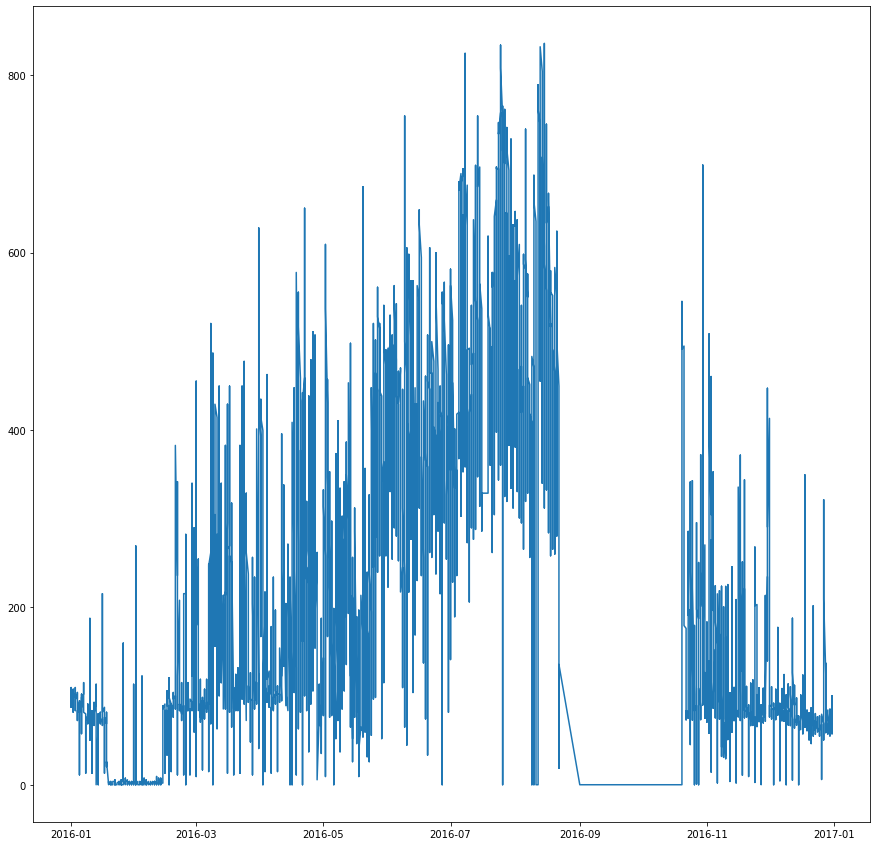

In [200]:
plt.figure(figsize=(15,15))
plt.plot(pd.to_datetime(test["timestamp"]).dt.date, test['meter_reading'])

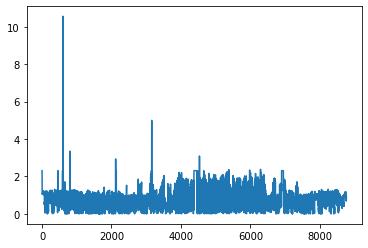

In [148]:
z = np.abs(stats.zscore(test['meter_reading']))
pd.Series(z).describe()
plt.plot(z)

In [22]:
test = test[(np.abs(stats.zscore(test['meter_reading'])) < 20)]

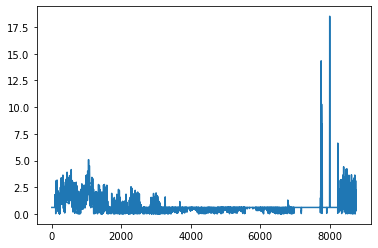

In [23]:
z = np.abs(stats.zscore(test['meter_reading']))
pd.Series(z).describe()
plt.plot(z)

In [235]:
### Testing Prophet ###
#test_ts = test[['timestamp', 'meter_reading']]
#test_ts['timestamp'] = pd.to_datetime(test_ts["timestamp"])
#test_ts = test_ts.set_index('timestamp')
#test_ts = test_ts.meter_reading.fillna(test_ts.meter_reading.rolling(969,min_periods=1).mean())
#test_ts.isnull().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


0

In [ ]:
#test_ts.plot(style=['k--', 'bo-', 'r*'], figsize=(20, 10))

In [172]:
################ Manual check of singe buildings ##################
df_train_elec = df_train[(df_train['site_id'] == 14) & (df_train['meter'] == 1)] 
df_train_elec_test = df_train_elec[df_train_elec['building_id'] == 753]

In [173]:
df_train_elec.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,is_constant_meter
3022992,7,1,2016-02-29 09:00:00,1857.260,0,Education,121074,1989.000,nan,13.300,9.635,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022993,9,1,2016-02-29 09:00:00,590.945,0,Office,27000,2010.000,nan,13.300,9.347,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022994,13,1,2016-02-29 09:00:00,1224.100,0,Education,99380,2000.000,nan,13.300,7.035,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022995,14,1,2016-02-29 09:00:00,1435.150,0,Education,86250,2013.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan
3022996,15,1,2016-02-29 09:00:00,422.104,0,Office,83957,1974.000,nan,13.300,9.731,11.100,0.000,1023.100,0.000,0.000,0.000,29,9,0,nan


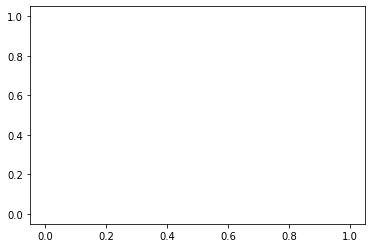

In [148]:
#z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
#plt.plot(z)

In [149]:
#df_train_elec['building_id'].unique()

array([  7,   9,  13,  14,  15,  29,  30,  31,  43,  50,  55,  60,  75,
        76,  78,  82,  91,  92,  95,  96,  97, 103,  28,  98])

In [150]:
#test = df_train_elec.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
#df_train_elec_test[(np.abs(stats.zscore(df_train_elec_test['meter_reading'])) < 5)]
#test.shape

In [203]:
#df_train_elec = df_train[(df_train['meter'] ==  1) & (df_train['building_id'] == 7)] 

In [152]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-09-24 20:00:00')]

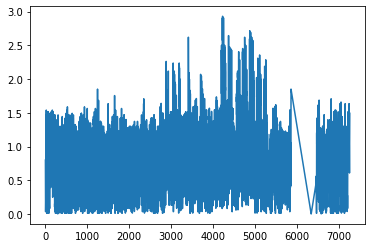

In [154]:
#z = np.abs(stats.zscore(df_train_elec['meter_reading']))
#pd.Series(z).describe()
#plt.plot(z)

In [155]:
#df_train_elec[pd.to_datetime(df_train_elec['timestamp']) > pd.to_datetime('2016-05-20 17:00:00')].head(30) 

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  """Entry point for launching an IPython kernel.


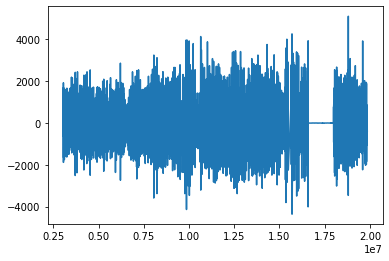

In [204]:
#plt.plot(df_train_elec['meter_reading'].rolling(2).apply(roll_diff))

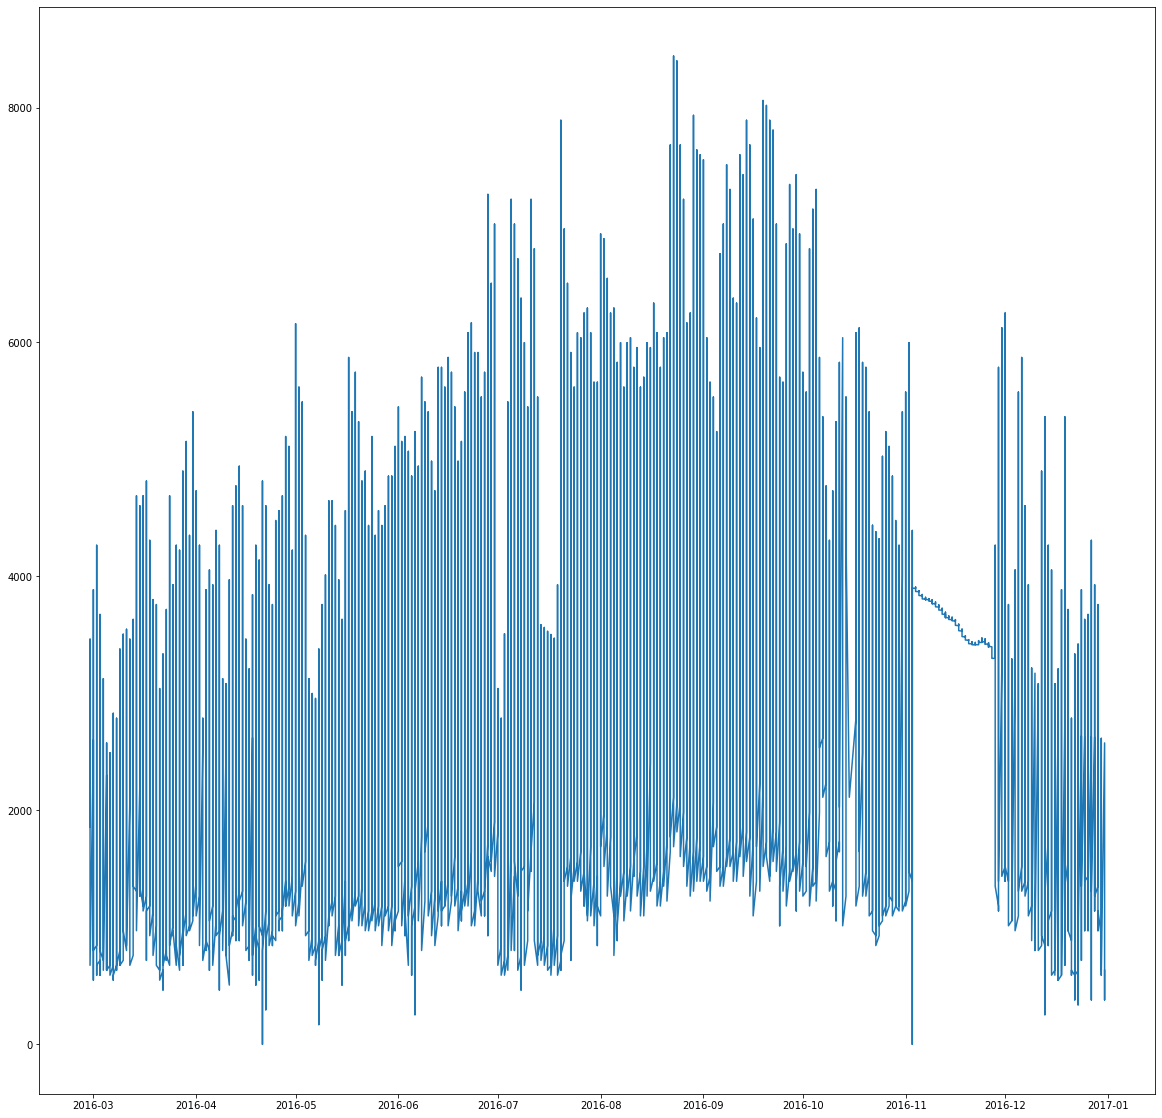

In [205]:
plt.figure(figsize=(20,20))
plt.plot(pd.to_datetime(df_train_elec["timestamp"]).dt.date, df_train_elec['meter_reading'])

In [879]:
#df_train = df_train[df_train["meter_reading"] != 0.0]

In [880]:
#encode_cols = ["primary_use"]

In [881]:
#data = dp.encode_categorical(df_train, df_test, encode_cols) 

In [882]:
#mb = mc.modelBuilder('regression', 'LGBM')

In [883]:
#data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                             target = 'meter_reading', rem_cols = ['timestamp'], 
#                             useVarImp = False, varimp_threshold = 100)

In [884]:
#data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)

In [ ]:
#data['Y'] = np.log(data['Y'])

In [102]:
#data['Y'][data['Y'] == -inf] = 0

In [ ]:
#data['Y'].describe()

In [3]:
########## Create Features#############

def create_lag_features(df, window):
    """
    Creating lag-based features looking back in time.
    """
    
    feature_cols = ["air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr"]
    df_site = df.groupby("site_id")
    
    df_rolled = df_site[feature_cols].rolling(window=window, min_periods=0)
    
    df_mean = df_rolled.mean().reset_index().astype(np.float16)
    df_median = df_rolled.median().reset_index().astype(np.float16)
    df_min = df_rolled.min().reset_index().astype(np.float16)
    df_max = df_rolled.max().reset_index().astype(np.float16)
    df_std = df_rolled.std().reset_index().astype(np.float16)
    df_skew = df_rolled.skew().reset_index().astype(np.float16)
    
    for feature in tqdm_notebook(feature_cols):
        df[f"{feature}_mean_lag{window}"] = df_mean[feature]
        df[f"{feature}_median_lag{window}"] = df_median[feature]
        df[f"{feature}_min_lag{window}"] = df_min[feature]
        df[f"{feature}_max_lag{window}"] = df_max[feature]
        df[f"{feature}_std_lag{window}"] = df_std[feature]
        df[f"{feature}_skew_lag{window}"] = df_std[feature]
        
    return df

In [4]:
def create_log_features(df, cols):
    for col in tqdm_notebook(cols):
        df[f'{col}_log'] = np.log(df[col])
        df[f'{col}_log'].replace([np.inf, -np.inf], 0, inplace=True)
    return(df)

In [5]:
df_train = create_log_features(df_train, ["square_feet",                   
                                        "year_built",                    
                                        "floor_count"])

In [6]:
df_test = create_log_features(df_test, ["square_feet",                   
                                        "year_built",                    
                                        "floor_count"])

In [412]:
#df_train = create_lag_features(df_train, 18)
#df_test = create_lag_features(df_test, 18)

In [34]:
### Calculate Square Feet per Floor ####
df_train['sqfeet_per_floor'] = df_train['square_feet']/df_train['floor_count']
df_test['sqfeet_per_floor'] = df_test['square_feet']/df_test['floor_count']

In [26]:
df_train.shape

(19545435, 27)

In [25]:
df_train['square_feet'].describe()

count   19545435.000
mean      107993.397
std       117139.052
min          283.000
25%        33012.000
50%        73044.000
75%       139683.000
max       875000.000
Name: square_feet, dtype: float64

In [22]:
df_train.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid,sqfeet_per_floor
building_id,1.000,0.208,0.009,0.980,0.084,-0.213,-0.370,-0.317,-0.158,-0.101,0.056,0.085,0.049,0.009,0.001,-0.003,-0.000,-0.000,0.327,0.003,-0.314,0.175,-0.177,-0.326,0.212
meter,0.208,1.000,0.018,0.241,0.131,0.021,0.191,-0.007,-0.143,-0.074,0.019,-0.049,-0.024,-0.080,0.001,-0.002,0.000,0.000,-0.091,-0.002,0.018,-0.086,0.083,0.048,0.112
meter_reading,0.009,0.018,1.000,0.012,0.025,0.132,0.133,-0.004,0.011,-0.003,-0.000,-0.004,0.000,0.006,-0.001,-0.000,0.001,-0.001,0.001,0.000,-0.005,-0.001,0.001,-0.002,0.139
site_id,0.980,0.241,0.012,1.000,0.088,-0.181,-0.357,-0.309,-0.124,-0.127,0.052,0.062,0.051,0.017,0.001,-0.003,-0.000,-0.000,0.280,0.003,-0.295,0.131,-0.135,-0.295,0.218
square_feet,0.084,0.131,0.025,0.088,1.000,0.146,0.569,-0.015,-0.003,-0.022,0.039,-0.019,-0.017,-0.034,0.000,-0.001,0.000,0.000,-0.008,-0.004,0.000,-0.005,0.002,-0.017,0.522
year_built,-0.213,0.021,0.132,-0.181,0.146,1.000,0.133,0.171,0.084,0.101,-0.023,-0.031,-0.063,-0.049,0.002,0.004,0.000,-0.000,-0.101,-0.006,0.167,-0.003,-0.002,0.063,0.051
floor_count,-0.370,0.191,0.133,-0.357,0.569,0.133,1.000,-0.182,-0.211,-0.167,0.145,-0.044,0.073,-0.018,-0.002,-0.002,-0.000,0.001,0.048,0.012,-0.187,-0.114,0.120,-0.080,-0.078
air_temperature,-0.317,-0.007,-0.004,-0.309,-0.015,0.171,-0.182,1.000,-0.010,0.751,0.017,-0.314,-0.099,-0.086,-0.055,0.026,0.156,-0.006,-0.445,-0.007,0.933,0.096,-0.096,0.509,-0.017
cloud_coverage,-0.158,-0.143,0.011,-0.124,-0.003,0.084,-0.211,-0.010,1.000,0.064,0.050,-0.113,0.013,0.193,-0.005,0.006,0.040,-0.000,0.101,-0.001,0.005,0.070,-0.077,-0.063,0.037
dew_temperature,-0.101,-0.074,-0.003,-0.127,-0.022,0.101,-0.167,0.751,0.064,1.000,0.089,-0.222,-0.174,-0.145,-0.043,0.026,-0.008,-0.005,0.257,0.007,0.609,0.643,-0.643,-0.034,-0.082


In [30]:
df_train = df_train[df_train.columns.drop(list(df_train.filter(regex='log')))]
df_test = df_test[df_test.columns.drop(list(df_test.filter(regex='log')))]

In [35]:
df_test.dtypes

row_id                          int64
building_id                     int64
meter                           int64
timestamp                      object
site_id                         int64
primary_use                    object
square_feet                     int64
year_built                    float64
floor_count                   float64
air_temperature               float64
cloud_coverage                float64
dew_temperature               float64
precip_depth_1_hr             float64
sea_level_pressure            float64
wind_direction                float64
wind_speed                    float64
IsHoliday                     float64
Day                             int64
Hour                            int64
DayOfWeek                       int64
relative_humidity             float64
air_density_dry               float64
vapor_pressure_water_satur    float64
vapor_pressure_water          float64
partial_press_dry             float64
air_density_humid             float64
sqfeet_per_f

In [3]:
def rmse(y, yhat):
    score = sqrt(mean_squared_error(y, yhat))
    return(score)

In [29]:
# LGBM params
params = {
    'boosting_type':'gbdt',
    'n_estimators':300,
    'num_leaves':32, 
    'objective':'regression_l2', 
    'colsample_bytree': 1.0, 
    'learning_rate': 0.05,
    'max_bin':255, 
    'max_depth':9, 
    'metric':'rmse', 
    'min_child_samples':10,
    'min_child_weight':5, 
    'min_split_gain':0.0,
    'random_state':1234,
    'lambda_l2': 1.5,
    'verbose' : 2,
    #'reg_alpha':0.0,
    #'reg_lambda':0.0, 
    #'silent':True, 
    'subsample':1.0
    #,
    #'early_stopping_round' : 100
}

In [10]:
### CatBoost params
params = {
    'iterations':500,
    'learning_rate' : 0.3,
    'depth' : 9,
    'loss_function' : 'RMSE',
    'verbose' : 2,
    'eval_metric': 'RMSE',
}

In [7]:
### XgBoost params
params = {
    'n_estimators':700,
    'objective':'reg:squarederror',
    'max_leaves' : 32,
    'n_jobs': 50,
    'learning_rate' : 0.01,
    'max_depth' : 9,
    'loss_function' : 'rmse',
    'verbosity' : 0,
    'eval_metric': 'rmse'
}

In [10]:
df_train.corr()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,IsHoliday,Day,Hour,DayOfWeek,relative_humidity,air_density_dry,vapor_pressure_water_satur,vapor_pressure_water,partial_press_dry,air_density_humid,square_feet_log,year_built_log,floor_count_log
building_id,1.000,0.208,0.009,0.980,0.084,-0.213,-0.370,-0.317,-0.158,-0.101,0.056,0.085,0.049,0.009,0.001,-0.003,-0.000,-0.000,0.327,0.003,-0.314,0.175,-0.177,-0.326,0.156,-0.213,-0.511
meter,0.208,1.000,0.018,0.241,0.131,0.021,0.191,-0.007,-0.143,-0.074,0.019,-0.049,-0.024,-0.080,0.001,-0.002,0.000,0.000,-0.091,-0.002,0.018,-0.086,0.083,0.048,0.219,0.022,0.187
meter_reading,0.009,0.018,1.000,0.012,0.025,0.132,0.133,-0.004,0.011,-0.003,-0.000,-0.004,0.000,0.006,-0.001,-0.000,0.001,-0.001,0.001,0.000,-0.005,-0.001,0.001,-0.002,0.018,0.132,0.112
site_id,0.980,0.241,0.012,1.000,0.088,-0.181,-0.357,-0.309,-0.124,-0.127,0.052,0.062,0.051,0.017,0.001,-0.003,-0.000,-0.000,0.280,0.003,-0.295,0.131,-0.135,-0.295,0.175,-0.181,-0.515
square_feet,0.084,0.131,0.025,0.088,1.000,0.146,0.569,-0.015,-0.003,-0.022,0.039,-0.019,-0.017,-0.034,0.000,-0.001,0.000,0.000,-0.008,-0.004,0.000,-0.005,0.002,-0.017,0.776,0.146,0.489
year_built,-0.213,0.021,0.132,-0.181,0.146,1.000,0.133,0.171,0.084,0.101,-0.023,-0.031,-0.063,-0.049,0.002,0.004,0.000,-0.000,-0.101,-0.006,0.167,-0.003,-0.002,0.063,0.137,1.000,0.043
floor_count,-0.370,0.191,0.133,-0.357,0.569,0.133,1.000,-0.182,-0.211,-0.167,0.145,-0.044,0.073,-0.018,-0.002,-0.002,-0.000,0.001,0.048,0.012,-0.187,-0.114,0.120,-0.080,0.560,0.133,0.887
air_temperature,-0.317,-0.007,-0.004,-0.309,-0.015,0.171,-0.182,1.000,-0.010,0.751,0.017,-0.314,-0.099,-0.086,-0.055,0.026,0.156,-0.006,-0.445,-0.007,0.933,0.096,-0.096,0.509,-0.036,0.171,-0.239
cloud_coverage,-0.158,-0.143,0.011,-0.124,-0.003,0.084,-0.211,-0.010,1.000,0.064,0.050,-0.113,0.013,0.193,-0.005,0.006,0.040,-0.000,0.101,-0.001,0.005,0.070,-0.077,-0.063,-0.074,0.083,-0.275
dew_temperature,-0.101,-0.074,-0.003,-0.127,-0.022,0.101,-0.167,0.751,0.064,1.000,0.089,-0.222,-0.174,-0.145,-0.043,0.026,-0.008,-0.005,0.257,0.007,0.609,0.643,-0.643,-0.034,-0.063,0.100,-0.214


In [11]:
#gc.collect()

In [12]:
#df_train_build = df_train[(df_train['building_id'] == 46) & (df_train['meter'] == 0)]

In [13]:
#df_train_build.head(20)

In [14]:
#submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                      save_varimp = True, params = params, oversmp = False, cv_shuffle=False)

In [ ]:
#df_train = df_train.drop(['is_constant_meter'], axis = 1)

In [456]:
#df_train[df_train['meter_reading'] < 0]['meter_reading'] = 0 

In [ ]:
#### Replace Constants with Prophet ####
#df_train_final = pd.read_csv('./df_train_prophet_for_constants.csv', compression = 'gzip')
#df_train_prophet = df_train_final[['timestamp', 'building_id', 'meter', 'meter_reading']]
#df_train_prophet.columns = ['timestamp', 'building_id', 'meter', 'meter_reading_prophet']
#df_train = df_train.merge(df_train_prophet, on = ['timestamp', 'building_id', 'meter'])
#df_train.meter_reading.fillna(df_train.meter_reading_prophet, inplace=True)
#df_train = df_train.drop(['meter_reading_prophet','is_constant_meter'], axis = 1)

In [8]:
df_train = df_train[~(df_train['site_id'].isnull())]

In [6]:
param_hyperparam ={'num_leaves': [16, 32, 64],
                   'learning_rate' : [0.01, 0.03, 0.05, 0.07, 0.1],
                   'max_depth': [7, 9, 11, 13] 
                  }

In [38]:
# import lightgbm as lgb
# from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# import sklearn as sk

In [47]:
# def hyperparam_tuning(prep_data, problem_type, model_type,param_grid, n_iter_hp, metric, n_folds, params = None):
#         """
#         Function to enable hyperparameters tunning.
#         """
#         X = prep_data['X']
#         Y = prep_data['Y']
#         X_test = prep_data['X_test']
        
#         if problem_type == 'regression':
            
#             if model_type == 'LGBM':
#                 fit_model = lgb.LGBMRegressor(**params)
            
#             elif model_type == 'CatBoost':
#                 fit_model = cat.CatBoostRegressor()                                                    
            
#             elif model_type == 'XGBoost':
#                 fit_model = xgb.XGBRegressor()

#             else : 
#                 print(f'This {model_type} is not yet supported!')

#         elif problem_type == 'classification':

#             if model_type == 'LGBM':
#                 fit_model = lgb.LGBMClassifier()

#             elif model_type == 'XGBoost':
#                 fit_model = xgb.XGBClassifier()

#             else: 
#                 print(f'{model_type} for classification is not yet supported')

#         else: 
#             print(f'{problem_type} type of a problem solving is not yet supported')
            
#         gs = RandomizedSearchCV(estimator=fit_model, param_distributions=param_grid, n_iter=n_iter_hp, scoring=metric, cv=n_folds, refit=True, random_state=314, verbose=True)
#         gs.fit(X, Y)

#         print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

#         return(gs)

In [ ]:
### Per site and meter type ###
perf_dict = {}
final_sub_lst = []
encode_cols = ["primary_use"]
mb = mc.modelBuilder('regression', 'LGBM')
for i in tqdm_notebook(df_train['site_id'].unique()):#
#for i in tqdm_notebook(range(8, 9, 1)):
    print(f'training site_id {i}')
    
    df_train_site = df_train[df_train['site_id'] == i]
    df_test_site = df_test[df_test['site_id'] == i]
    
    for j in df_train_site['meter'].unique():
        
        print(f'training meter {j}')
        df_train_metr = df_train_site[df_train_site['meter'] == j]
        df_test_metr = df_test_site[df_test_site['meter'] == j]

        df_train_metr = df_train_metr[(np.abs(stats.zscore(df_train_metr['meter_reading'])) < 5)]
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
        #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[x['meter_reading'] < x['meter_reading'].quantile(0.99)])
        
        data = dp.encode_categorical(df_train_metr, df_test_metr, encode_cols)
        data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
                                 target = 'meter_reading', rem_cols = ['timestamp'], 
                                 useVarImp = False, varimp_threshold = 100)
        data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
        data['Y'] = np.log(data['Y'])
        data['Y'][data['Y'] == -inf] = 0
        
        ### test hyperparameters ###
        #gs = mb.hyperparam_tuning(data, search_type = 'randomized', param_grid = param_hyperparam, n_iter_hp = 100, metric = 'neg_mean_squared_error', n_folds = 3, params = params)
        ############################
        
        submit = mb.run_model(data, n_folds = 3, metric_func = rmse, get_probab = False, 
                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False, 
                              hyperparam_tunning = False, search_type = 'randomized', 
                              param_grid = param_hyperparam, n_iter_hp = 100, 
                              metric = 'neg_mean_squared_error')
        submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
        final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

        perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
        final_sub_lst.append(final_submit)
    

training site_id 1.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.25474982393959783
Fold: 1
The valuation metric for the fold 1 is 0.67256397336865
Fold: 2
The valuation metric for the fold 2 is 0.4524829967650696
The average score accross the folds is 0.4599322646911059
training meter 3.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.5092354705375444
Fold: 1
The valuation metric for the fold 1 is 1.7711069912237014
Fold: 2
The valuation metric for the fold 2 is 1.8166209522502057
The average score accross the folds is 1.6989878046704838
training site_id 2.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.4746836603322634
Fold: 1
The valuation metric for the fold 1 is 0.376041626820226
Fold: 2
The valuation metric for the fold 2 is 0.41560908226282306
The average score accross the folds is 0.4221114564717708
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.2719479239967761
Fold: 1
The valuation metric for the fold 1 is 1.0902515042813286
Fold: 2
The valuation metric for the fold 2 is 1.218785588038487
The average score accross the folds is 1.1936616721055306
training meter 3.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.1819095246110392
Fold: 1
The valuation metric for the fold 1 is 0.7650329100972295
Fold: 2
The valuation metric for the fold 2 is 1.1257452815202538
The average score accross the folds is 1.0242292387428409
training site_id 3.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.5610572719320929
Fold: 1
The valuation metric for the fold 1 is 0.4591582121944036
Fold: 2
The valuation metric for the fold 2 is 0.5411125821965493
The average score accross the folds is 0.5204426887743486
training site_id 4.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.25001388318725765
Fold: 1
The valuation metric for the fold 1 is 0.28818006475282953
Fold: 2
The valuation metric for the fold 2 is 0.26790267638132126
The avera

/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3297333793972081
Fold: 1
The valuation metric for the fold 1 is 0.35642195700382046
Fold: 2
The valuation metric for the fold 2 is 0.3792693835772046
The average score accross the folds is 0.3551415733260777
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.7515079525424373
Fold: 1
The valuation metric for the fold 1 is 1.3369309657474902
Fold: 2
The valuation metric for the fold 2 is 1.7103094136789234
The average score accross the folds is 1.5995827773229505
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.528726666500731
Fold: 1
The valuation metric for the fold 1 is 1.6292887014863784
Fold: 2
The valuation metric for the fold 2 is 1.7932983342908622
The average score accross the folds is 1.650437900759324
training site_id 7.0
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.153885316104387
Fold: 1
The valuation metric for the fold 1 is 1.5036142429890316
Fold: 2
The valuation metric for the fold 2 is 1.592754004677981
The average score accross the folds is 1.4167511879237997
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 1.449560193954717
Fold: 1
The valuation metric for the fold 1 is 1.4587408467719813
Fold: 2
The valuation metric for the fold 2 is 1.8032133513671291
The average score accross the folds is 1.570504797364609
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.14640776298818042
Fold: 1
The valuation metric for the fold 1 is 0.455161871658591
Fold: 2
The valuation metric for the fold 2 is 0.3923508798717148
The average score accross the folds is 0.33130683817282874
training meter 3.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.3728581003308775
Fold: 1
The valuation metric for the fold 1 is 2.4964764630841723
Fold: 2
The valuation metric for the fold 2 is 2.0560301886078465
The average score accross the folds is 1.9751215840076322
training site_id 8.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.7415719239656767
Fold: 1
The valuation metric for the fold 1 is 0.7012729957456476
Fold: 2
The valuation metric for the fold 2 is 0.6648918552980307
The average score accross the folds is 0.7025789250031185
training site_id 9.0
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.2300257816563664
Fold: 1
The valuation metric for the fold 1 is 1.3121118008339374
Fold: 2
The valuation metric for the fold 2 is 1.3133807888570104
The average score accross the folds is 1.2851727904491048
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.2531152165041266
Fold: 1
The valuation metric for the fold 1 is 1.3215459081212269
Fold: 2
The valuation metric for the fold 2 is 1.1999580034225283
The average score accross the folds is 1.2582063760159607
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.2723979422793803
Fold: 1
The valuation metric for the fold 1 is 0.21771758283117906
Fold: 2
The valuation metric for the fold 2 is 0.24878497855263035
The average score accross the folds is 0.2463001678877299
training site_id 10.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.4225452557865572
Fold: 1
The valuation metric for the fold 1 is 0.4085256106259856
Fold: 2
The valuation metric for the fold 2 is 0.49369039526985253
The average score accross the folds is 0.44158708722746515
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.03161225454074
Fold: 1
The valuation metric for the fold 1 is 1.6200641513064158
Fold: 2
The valuation metric for the fold 2 is 1.9094795797940214
The average score accross the folds is 1.8537186618803922
training meter 3.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 2.092915743866696
Fold: 1
The valuation metric for the fold 1 is 1.91294411568604
Fold: 2
The valuation metric for the fold 2 is 2.1854493836482916
The average score accross the folds is 2.063769747733676
training site_id 11.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.13642764993946804
Fold: 1
The valuation metric for the fold 1 is 0.2141793960423598
Fold: 2
The valuation metric for the fold 2 is 0.19017825275371505
The average score accross the folds is 0.18026176624518098
training meter 3.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.7438044761786717
Fold: 1
The valuation metric for the fold 1 is 1.3259226464475529
Fold: 2
The valuation metric for the fold 2 is 1.18616555775773
The average score accross the folds is 1.0852975601279848
training meter 1.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 0.44251384546154193
Fold: 1
The valuation metric for the fold 1 is 1.872324379846232
Fold: 2
The valuation metric for the fold 2 is 1.202583669459309
The average score accross the folds is 1.172473964922361
training site_id 12.0
training meter 0.0
colums primary_use is being encoded
24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3085782751123648
Fold: 1
The valuation metric for the fold 1 is 0.3395524515385393
Fold: 2
The valuation metric for the fold 2 is 0.31541669952792234
The average score accross the folds is 0.32118247539294215
training site_id 13.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.3325417908384117
Fold: 1
The valuation metric for the fold 1 is 0.383368037198958
Fold: 2
The valuation metric for the fold 2 is 0.3891272446947895
The average score accross the folds is 0.3683456909107197
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.136414918208257
Fold: 1
The valuation metric for the fold 1 is 1.0894296759993312
Fold: 2
The valuation metric for the fold 2 is 1.0589154179966263
The average score accross the folds is 1.0949200040680716
training meter 2.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



Fold: 0
The valuation metric for the fold 0 is 1.2641859473242691
Fold: 1
The valuation metric for the fold 1 is 1.669788036390037
Fold: 2
The valuation metric for the fold 2 is 1.3686883019916547
The average score accross the folds is 1.4342207619019869
training site_id 14.0
training meter 0.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0
The valuation metric for the fold 0 is 0.30776041415107225
Fold: 1
The valuation metric for the fold 1 is 0.29947800999710633
Fold: 2
The valuation metric for the fold 2 is 0.3199140722717022
The average score accross the folds is 0.30905083213996026
training meter 1.0
colums primary_use is being encoded


/opt/conda/lib/python3.7/site-packages/bearinmind_pipeline/data_preprocessing.py:60: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



24 features have been chosen for modeling
Fold: 0


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning:

divide by zero encountered in log



The valuation metric for the fold 0 is 1.8256835527018689
Fold: 1
The valuation metric for the fold 1 is 1.3994683875600882
Fold: 2


In [ ]:
### Per meter type ###
perf_dict = {}
final_sub_lst = []
encode_cols = ["primary_use"]
mb = mc.modelBuilder('regression', 'LGBM')
for j in tqdm_notebook(df_train['meter'].unique()):#
#for i in tqdm_notebook(range(8, 9, 1)):
    #print(f'training site_id {i}')
    
    #df_train_site = df_train[df_train['site_id'] == i]
    #df_test_site = df_test[df_test['site_id'] == i]
    
    #for j in df_train_site['meter'].unique():
        
    print(f'training meter {j}')
    df_train_metr = df_train[df_train['meter'] == j]
    df_test_metr = df_test[df_test['meter'] == j]

    df_train_metr = df_train_metr[(np.abs(stats.zscore(df_train_metr['meter_reading'])) < 5)]
    #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
    #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[x['meter_reading'] < x['meter_reading'].quantile(0.99)])
        
    data = dp.encode_categorical(df_train_metr, df_test_metr, encode_cols)
    data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
                                 target = 'meter_reading', rem_cols = ['timestamp', 'meter'], 
                                 useVarImp = False, varimp_threshold = 100)
    data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
    data['Y'] = np.log(data['Y'])
    data['Y'][data['Y'] == -inf] = 0
        
    ### test hyperparameters ###
    #gs = mb.hyperparam_tuning(data, search_type = 'randomized', param_grid = param_hyperparam, n_iter_hp = 100, metric = 'neg_mean_squared_error', n_folds = 3, params = params)
    ############################
        
    submit = mb.run_model(data, n_folds = 3, metric_func = rmse, get_probab = False, 
                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False, 
                              hyperparam_tunning = False, search_type = 'randomized', 
                              param_grid = param_hyperparam, n_iter_hp = 100, 
                              metric = 'neg_mean_squared_error')
    submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
    final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

    perf_dict[f'meter: {j}'] = submit['AverageScore']
    final_sub_lst.append(final_submit)
    

In [ ]:
### Per site id ###
perf_dict = {}
final_sub_lst = []
encode_cols = ["primary_use"]
mb = mc.modelBuilder('regression', 'LGBM')
for j in tqdm_notebook(df_train['site_id'].unique()):#
#for i in tqdm_notebook(range(8, 9, 1)):
    #print(f'training site_id {i}')
    
    #df_train_site = df_train[df_train['site_id'] == i]
    #df_test_site = df_test[df_test['site_id'] == i]
    
    #for j in df_train_site['meter'].unique():
        
    print(f'training site_id {j}')
    df_train_metr = df_train[df_train['site_id'] == j]
    df_test_metr = df_test[df_test['site_id'] == j]

    df_train_metr = df_train_metr[(np.abs(stats.zscore(df_train_metr['meter_reading'])) < 5)]
    #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[(np.abs(stats.zscore(x['meter_reading'])) < 5)])
    #df_train_metr = df_train_metr.groupby('building_id', as_index=False).apply(lambda x: x[x['meter_reading'] < x['meter_reading'].quantile(0.99)])
        
    data = dp.encode_categorical(df_train_metr, df_test_metr, encode_cols)
    data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
                                 target = 'meter_reading', rem_cols = ['timestamp', 'site_id'], 
                                 useVarImp = False, varimp_threshold = 100)
    data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
    data['Y'] = np.log(data['Y'])
    data['Y'][data['Y'] == -inf] = 0
        
    ### test hyperparameters ###
    #gs = mb.hyperparam_tuning(data, search_type = 'randomized', param_grid = param_hyperparam, n_iter_hp = 100, metric = 'neg_mean_squared_error', n_folds = 3, params = params)
    ############################
        
    submit = mb.run_model(data, n_folds = 3, metric_func = rmse, get_probab = False, 
                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False, 
                              hyperparam_tunning = False, search_type = 'randomized', 
                              param_grid = param_hyperparam, n_iter_hp = 100, 
                              metric = 'neg_mean_squared_error')
    submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
    final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

    perf_dict[f'site_id: {j}'] = submit['AverageScore']
    final_sub_lst.append(final_submit)
    

In [ ]:
### Per meter type ###
#perf_dict = {}
#final_sub_lst = []
#encode_cols = ["primary_use"]
#mb = mc.modelBuilder('regression', 'LGBM')
#for i in tqdm_notebook(df_train['site_id'].unique()):
#for i in tqdm_notebook(range(2)):
#    print(f'training site_id {i}')
#    
#    df_train_site = df_train[df_train['site_id'] == i]
#    df_test_site = df_test[df_test['site_id'] == i]

#    data = dp.encode_categorical(df_train_site, df_test_site, encode_cols)
#    data = mb.prepare_data_split(df_train =  data['df_train'], df_test = data['df_test'], 
#                                 target = 'meter_reading', rem_cols = ['timestamp'], 
#                                 useVarImp = False, varimp_threshold = 100)
#    data['X_test'] = data['X_test'].drop(["row_id"],  axis=1)
#    data['Y'] = np.log(data['Y'])
#    data['Y'][data['Y'] == -inf] = 0
#    submit = mb.run_model(data, n_folds = 5, metric_func = rmse, get_probab = False, 
#                          save_varimp = False, params = params, oversmp = False, cv_shuffle=False)
#    submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])
#    final_submit = pd.concat([df_test_metr['row_id'].reset_index(drop=True), pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

#    perf_dict[f'site_id: {i} and meter: {j}'] = submit['AverageScore']
#    final_sub_lst.append(final_submit)
    

In [43]:
np.array(list(perf_dict.values())).mean()

1.0030794907013816

In [9]:
perf_dict

{'site_id: 1.0 and meter: 0.0': 0.4539676040982059,
 'site_id: 1.0 and meter: 3.0': 1.6951779741062636,
 'site_id: 2.0 and meter: 0.0': 0.4098324773527808,
 'site_id: 2.0 and meter: 1.0': 1.1875815764785396,
 'site_id: 2.0 and meter: 3.0': 1.0134662919476622,
 'site_id: 3.0 and meter: 0.0': 0.5053991136294215,
 'site_id: 4.0 and meter: 0.0': 0.26100153183383634,
 'site_id: 5.0 and meter: 0.0': 0.7390233799664653,
 'site_id: 6.0 and meter: 0.0': 0.34926002301625236,
 'site_id: 6.0 and meter: 2.0': 1.5968722736569412,
 'site_id: 6.0 and meter: 1.0': 1.6433520072751702,
 'site_id: 7.0 and meter: 1.0': 1.381042803515161,
 'site_id: 7.0 and meter: 2.0': 1.5556755262037762,
 'site_id: 7.0 and meter: 0.0': 0.31896049595518156,
 'site_id: 7.0 and meter: 3.0': 1.9304585743653397,
 'site_id: 8.0 and meter: 0.0': 0.6966583555777123,
 'site_id: 9.0 and meter: 1.0': 1.2653778731994667,
 'site_id: 9.0 and meter: 2.0': 1.257436765431242,
 'site_id: 9.0 and meter: 0.0': 0.23814230695428565,
 'site_id:

In [10]:
with open('rmse_siteid_meter_no_zeros_lgbm_3folds.txt', 'w') as file:
     file.write(json.dumps(perf_dict))

In [44]:
sub = pd.concat(final_sub_lst, axis = 0).reset_index(drop = True)
sub.to_csv("submit_lightgbm_by_site_3fold.csv.gz", index = False, compression='gzip')

In [ ]:
#submit['FinalPrediction'] = np.exp(submit['FinalPrediction'])

In [ ]:
#submit['FinalPrediction']

In [ ]:
#submit

In [ ]:
#final_submit = pd.concat([df_test['row_id'], pd.DataFrame(submit['FinalPrediction'], columns = ["meter_reading"])], axis = 1)

In [ ]:
#final_submit["meter_reading"].describe()

In [ ]:
#final_submit.to_csv("submit_lightgbm_default.csv.gz", index = False, compression='gzip')

In [31]:
sub[sub['row_id'].isin([0,1,2,3,4,5])]

,row_id,meter_reading
39858000,0,182.944
39858001,1,82.287
39858002,2,9.678
39858003,3,303.237
39858004,4,1239.861
39858005,5,15.136


In [45]:
!kaggle competitions submit -c ashrae-energy-prediction -f  submit_lightgbm_by_site_3fold.csv.gz -m "additional filters by site id and meter reaading"

100%|████████████████████████████████████████| 472M/472M [00:11<00:00, 41.8MB/s]
Successfully submitted to ASHRAE - Great Energy Predictor III